### Notebook for testing model functions with input data and examining output

To do:
* hydrology model uses a sustainable flow parameter, as in INCA. This is a fudge and needs replacing
* Add saturation excess to quick flow
* See notes in Word doc on the sediment equations, together with a to do list specifically relating to suspended sediment
* As sediment equations don't use stream velocity, the only thing it's used in at the moment is to calculate the reach time constant. Excessive, as it's two parameters. Consider (1) removing the time constant altogether and assuming all water leaves the reach within a time step, or (2) calculating velocity as v = Q/A, where A = L_reach * w_reach. This would replace two params (a and b) with w_reach

In [56]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
from scipy import optimize
import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
sn.set_context('notebook')

In [57]:
# SNOW ACCUMULATION AND MELT

# Source for priors for DDF: http://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=17753.wba
# To Do:
# (1) Add options for how temperature is assumed to vary through the day. At the moment, assume average
# temperature throughout the day. In future, could look at triangular or sinuosoidal variations throughout
# the day, to get a more accurate portrayal of the degree-days above the threshold.
# Also assumes no melting below 0 deg C.

# (2) Consider setting ET to 0 when D_snow > 0.

def hydrol_inputs(D_snow_0, f_DDSM, met_df):
    """Function to calculate snow accumulation and melt.
    Calculates total hydrological input to soil box as precipitation as precipitation as rain + snowmelt
    
    D_snow_0: Initial snow depth (mm)
    f_DDSM: Degree-day factor for snow melt (mm/degree-day deg C)
    met_df: Dataframe of met data with cols T_air, PET, Pptn
    
    Returns met_df with additional columns [P_snow, P_rain, P_melt, D_snow_start
    D_snow_end, P]
    
    Of these, P is the hydrological input to the soil store
    """

    # Calculate precipitation falling as snow and add to met_df
    met_df.loc[:,'P_snow'] = met_df['Pptn'].ix[met_df['T_air']<0]
    met_df['P_snow'].fillna(0, inplace=True)

    # Calculate precipitation falling as rain and add to met_df
    met_df['P_rain'] = met_df['Pptn'] - met_df['P_snow']

    # Calculate daily snow melt, if unlimited snow pack depth to melt (mm/day)
    met_df['P_melt'] = f_DDSM*(met_df['T_air']-0)
    met_df['P_melt'][met_df['P_melt']<0]=0  # Set negative values to 0

    # Calculate snow pack depth
    met_df['D_snow_start'] = np.nan
    met_df['D_snow_end'] = np.nan

    # First time-step manually, to take initial condition into account
    met_df.ix[0,'D_snow_start'] = D_snow_0 #Assign start snow depth to first row
    met_df.ix[0,'P_melt'] = np.minimum(met_df.ix[0,'P_melt'],met_df.ix[0,'D_snow_start'])
    met_df.ix[0,'D_snow_end'] = met_df.ix[0,'D_snow_start']+met_df.ix[0,'P_snow']-met_df.ix[0,'P_melt']

    # Calculte for subsequent days
    for idx in range (1,len(met_df)):
        met_df.ix[idx,'D_snow_start'] = met_df.ix[idx-1,'D_snow_end']
        met_df.ix[idx,'P_melt'] = np.minimum(met_df.ix[idx,'P_melt'],met_df.ix[idx,'D_snow_start'])
        met_df.ix[idx,'D_snow_end'] = met_df.ix[idx,'D_snow_start']+met_df.ix[idx,'P_snow']-met_df.ix[idx,'P_melt']

    # Hydrological input to soil box
    met_df.loc[:,'P'] = met_df['P_rain'] + met_df['P_melt']
    
    return met_df

In [58]:
def sed_model_1(met_df, ics, p, period, step_len=1):
    """ Firs hydrology & sediment model

            met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
            ics            Vector of initial conditions [Vs0, Qg0, Qr0]
            p              Series of parameter values (index = param name)
                           Includes the extra param q_gw_min
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)

        Returns a dataframe with column headings
        ['Vs', 'Qs', 'Vg', 'Qg', 'Vr', 'Qr', 'Dr','Qq', 'Mland']
        (soil water volume and flow, groundwater volume and flow, reach volume
        and flow, mean average daily flow in reach, quick flow)
        
        Future needs: Add in saturation excess to help simulate winter peaks
    """
    # ------------------------------------------------------------------------
    # Define the ODE system
    def ode_f(y, t, ode_params):
        """ Define ODE system.
                y is list or variables for which we want to determine their value at the end of
                    the time step
                    [Vs, Qs, Vg, Qg, Vr, Qr, Dr, Msus]
                t is an array of time points of interest
                params is a tuple of input values & model params:
                    (P, E, Qq_i, Mland_i, f_IExcess, alpha, beta, T_s, T_g, fc, L_reach, S_reach
                    a_Q, b_Q, E_Q, k_EQ)
        """
        # Unpack incremental values for initial conditions for this time step 
        Vs_i = y[0]
        Qs_i = y[1]
        Vg_i = y[2]
        Qg_i = y[3]
        Vr_i = y[4]
        Qr_i = y[5]
        Msus_i = y[7]
        
        # Unpack params
        (P, E, Qq_i, Mland_i, f_IExcess, alpha, beta, T_s,
         T_g, fc, L_reach, S_reach, a_Q, b_Q, E_Q, k_EQ) = ode_params
    
        # Soil equations (units mm or mm/day)
        dQs_dV = (((Vs_i - fc)*np.exp(fc - Vs_i))/(T_s*((np.exp(fc-Vs_i) + 1)**2)))
        +(1/(T_s*(np.exp(fc-Vs_i) + 1)))
        dVs_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*Vs_i)) - Qs_i
        dQs_dt = dQs_dV*dVs_dt
        
        # Groundwater equations (units mm or mm/day)
        dQg_dt = (beta*Qs_i - Qg_i)/T_g
        dVg_dt = beta*Qs_i - Qg_i
        
        # Instream equations (units m3 or m3/s)
        # Units: factors in dQr_dt convert units of instream velocity (aQ^b) from m/s to mm/s, the
        # time constant from s to days & L_reach from m to mm
        dQr_dt = ((Qq_i + (1-beta)*Qs_i + Qg_i) - Qr_i)* a_Q*(Qr_i**b_Q)*(8.64*10**7)/((1-b_Q)*(L_reach*1000))
        dVr_dt = (Qq_i + (1-beta)*Qs_i + Qg_i) - Qr_i
        dDr_dt = Qr_i
        
        # Instream suspended sediment (kg; change in kg/day)
        dMsus_dt = Mland_i + E_Q*S_reach*(Qr_i**k_EQ) - (Msus_i/Vr_i)*Qr_i #Units: (kg/day) - (kg/mm)*(mm/day)
        
        # Add results of equations to an array
        res = np.array([dVs_dt, dQs_dt, dVg_dt, dQg_dt, dVr_dt, dQr_dt, dDr_dt, dMsus_dt])
        
        return res
    # -------------------------------------------------------------------------

    # Unpack user-supplied initial conditions
    # (initial soil water volume, groundwater flow, instream flow)
    Vs0, Qg0, Qr0 = ics
    # Assume initial suspended sediment mass is 0 kg, and have short burn-in period
    Msus0 = 0.0

    # Time points to evaluate ODEs at. We're only interested in the start and
    # the end of each step
    ti = [0, step_len]

    # Lists to store output
    output_ODEs = []  # From ode_f function
    output_nonODE = []  # Will include: Qq, Mland

    # Loop over met data
    for idx in range(len(met_df)):

        # Get P and E for this day
        P = met_df.ix[idx, 'P']
        E = met_df.ix[idx, 'PET']

        # Calculate infiltration excess (mm/(day * catchment area))
        Qq_i = p['f_IExcess']*P
        
        # Calculate terrestrial erosion and delivery to the stream, Mland (kg/day)
        Mland_i = p['E_land']*(Qq_i**p['k_Eland']) #Units: (kg/mm)*(mm/day)
        
        # Append to results
        output_nonODE_i = [Qq_i, Mland_i]
        output_nonODE.append(output_nonODE_i)

        # Calculate additional initial conditions from user-input initial conditions
        # Soil and groundwater
        Qs0 = (Vs0 - p['fc'])/(p['T_s']*(1 + np.exp(p['fc'] - Vs0)))
        Vg0 = Qg0 *p['T_g']
        # Instream hydrol
        Tr0 = (1000*p['L_reach'])/(p['a_Q']*(Qr0**p['b_Q'])*(8.64*10**7)) #Reach time constant (days), where T=L/aQ^b
        Vr0 = Qr0*Tr0 # i.e. V=QT (mm)

        # Vector of initial conditions for start of time step
        # Assume 0 for Dr0 (daily mean instream Q)
        y0 = [Vs0, Qs0, Vg0, Qg0, Vr0, Qr0, 0.0, Msus0]

        # Model parameters plus rainfall and ET, for input to solver
        ode_params = np.array([P, E, Qq_i, Mland_i, p['f_IExcess'],p['alpha'], p['beta'],
                              p['T_s'], p['T_g'], p['fc'], p['L_reach'], p['S_reach'], p['a_Q'], p['b_Q'],
                              p['E_Q'], p['k_EQ']])

        # Solve
        y = odeint(ode_f, y0, ti, args=(ode_params,))

        # Extract values for end of step
        res = y[1]

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output_ODEs.append(res)

        # Update initial conditions for next step
        Vs0 = res[0]
        # FUDGE to re-set groundwater to user-supplied min flow at start of each time step!!!
        if param_dict['Qg_min'] > res[3]:
            Qg0 = p['Qg_min']
        else:
            Qg0 = res[3]
        Qr0 = res[5]
        Msus0 = res[7]

    # Build a dataframe of ODE results
    df1 = pd.DataFrame(data=np.vstack(output_ODEs),
                      columns=['Vs', 'Qs', 'Vg', 'Qg', 'Vr', 'Qr', 'Dr', 'Msus'],
                      index=met_df.index)
    
    # Dataframe of non ODE results
    df2 = pd.DataFrame(data=np.vstack(output_nonODE), columns=['Qq', 'Mland'],
                     index=met_df.index)

    # Concatenate results dataframes
    df = pd.concat([df1,df2], axis=1)

    return df

In [59]:
# USER INPUT

# Met and observed data file paths
metdata_fpath = r'M:\Working\NewModel\ModelInputs\Tar_AvMetData_1981-2010.csv'
Qobsdata_fpath = r'M:\Working\NewModel\ModelInputs\obs_csvs\Coull_9amDailyMeanQ_oldRating.csv'
chemObsData_fpath = r'M:\Working\NewModel\ModelInputs\obs_csvs\WholePeriod\TarChem_R4_SS-P.csv'

# Simulation period
st_dt = '2004-01-01'  # Start date
end_dt = '2005-12-31' # End date

# Include snow melt and accumulation module?
inc_snowmelt = 1

# Snow melt parameters
D_snow_0 = 0.  # Initial snow depth (mm)
f_DDSM = 2.74 # Degree-day factor for snow melt (mm/degree-day deg C)

# Model parameters, including starting guesses for those being calibrated
# Units: L_reach in mm for now. a_Q and b_Q are for m/s vs m3/s, therefore convert in script for now.
param_dict = {'A_catch': 51.7, 'L_reach':10000 , 'S_reach':0.8, 'fc':290, 'alpha':0.90, 'beta':0.6,
              'f_IExcess':0.015, 'T_s':6.,'T_g':60., 'Qg_min':0.4, 'a_Q':0.5, 'b_Q':0.5,
              'E_land':5000., 'k_Eland':1.2, 'E_Q': 300., 'k_EQ':1.7}
            # A_catch: catchment area (km2) Coull: 51.7; Aboyne: 73.7
            # E_land: Erodibility (kg/mm)
            # E_Q: Instream entrainment factor (kg/mm)
            # k_Eland, k_EQ: non-linear coefficients for sed delivery, entrainment

# Initial conditions
Vs0_init = param_dict['fc']       # Initial soil volume (mm)
Qg0_init = 1.                 # Initial groundwater flow (mm/day)
Qr0_init = 1.                 # Initial in-stream flow (m3/s)

In [60]:
# SET UP
ics=[Vs0_init, Qg0_init, Qr0_init]  # Initial conditions
period=[st_dt, end_dt]    # Simulation period

# Store parameter values in series, referenced by their names (the row indices)
p = pd.Series(param_dict)  # All params; cols = param names, one row with values

In [61]:
# READ IN INPUT DATA

met_df = pd.read_csv(metdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
Qobs_df = pd.read_csv(Qobsdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
chemObs_df = pd.read_csv(chemObsData_fpath, parse_dates=True, dayfirst=True, index_col=0)

# Truncate the met and observed data to the desired period
met_df = met_df.truncate(before=period[0], after=period[1])
Qobs_df = Qobs_df.truncate(before=period[0], after=period[1])
chemObs_df = chemObs_df.truncate(before=period[0], after=period[1])

# Linear interpolation of any missing values in the met data
met_df.interpolate(method='linear', inplace=True)

# # Convert cumecs to mm per day per catchment area
# Qobs_df['Obs_Runoff_mm'] = Qobs_df['Q_cumecs']*60*60*24*1000/p['A_catch']
# del Qobs_df['Q_cumecs']

# Combine Q and chem data into one df
obs_df = pd.concat([Qobs_df, chemObs_df], axis=1)

In [62]:
# RUN MODEL

# If desired, run snow module
if inc_snowmelt == 1:
    met_df = hydrol_inputs(D_snow_0, f_DDSM, met_df)
else:
    met_df.rename(columns={'Pptn':'P'}, inplace=True)

# Run model
df = sed_model_1(met_df=met_df, ics=ics, p=p, period=period)

# Add observed data and snow depth to simulated df
df['D_snow'] = met_df['D_snow_end']
df = pd.concat([df, obs_df], axis=1)
# Convert units
df['Sim_Q_cumecs'] = df['Dr']*p['A_catch']*1000/86400
df['Sim_Vr_l'] = df['Vr']*p['A_catch']*10**6

# Add suspended sediment concentration to results
df['Msus_mg-l'] = (df['Msus']/df['Vr']) * (1/(p['A_catch']*10**6))*10**6

# Work out proportion of sed that's 


Q NSE: 0.671425201373
Q NSE on logs 0.772414001785
Q Spearman's rank CC: 0.918525820968
Q R2: 0.740190543268
SS NSE: 0.00819060299853
SS NSE on logs 0.0109355438259
SS Spearman's rank CC: 0.301017193283
SS R2: 0.0253254146883


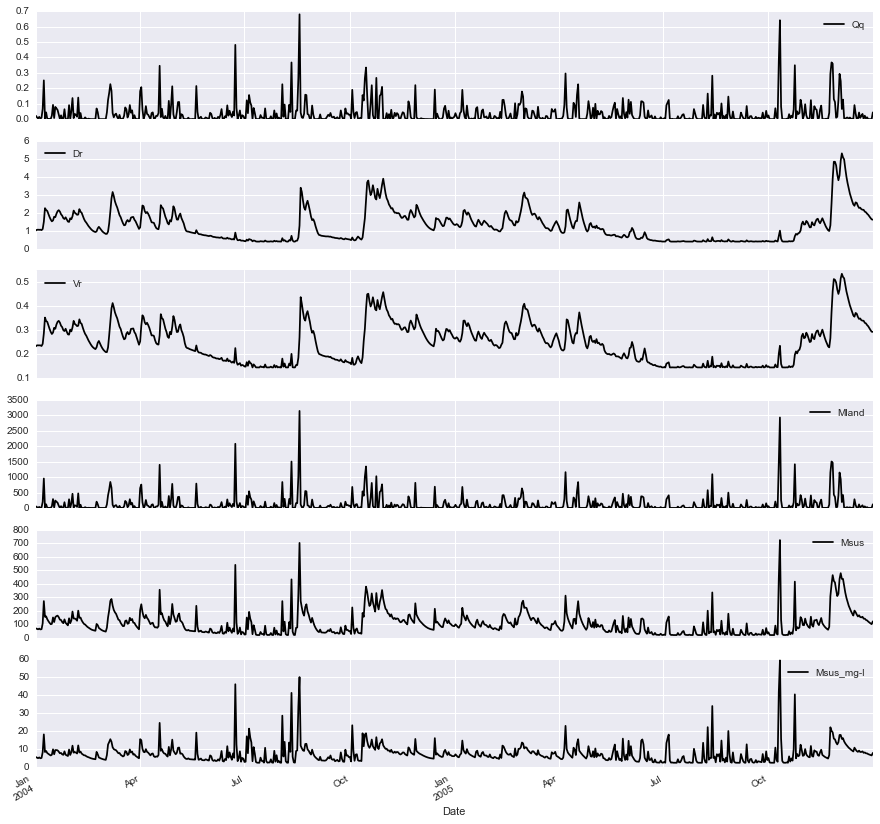

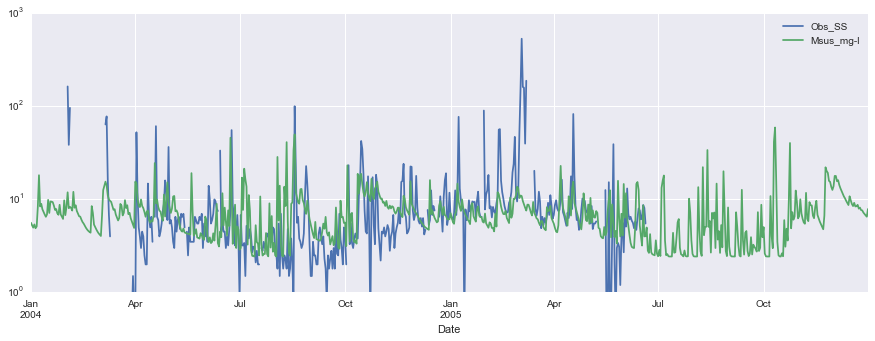

In [63]:
# EXAMINE OUTPUT

# Plot some timeseries

# Hydrology
# fig1 = df[['Sim_Q_cumecs', 'Obs_Q_cumecs']].plot(alpha=0.5,figsize=(15, 3))
# df_logs = np.log(df)
# fig2 = df_logs[['Sim_Q_cumecs', 'Obs_Q_cumecs']].plot(alpha=0.5,figsize=(15, 3))

# Internal stuff
# fig3 = df[['Vs','Qs', 'Vg','Qg','Vr','Qr','Dr','Mland', 'Msus', 'Msus_mg-l']].plot(subplots=True,figsize=(15, 10))
fig3 = df[['Qq','Dr','Vr','Mland', 'Msus', 'Msus_mg-l']].plot(subplots=True,figsize=(15, 15))

# Observed & simulated SS conc
fig4 = df[['Obs_SS', 'Msus_mg-l']].plot(figsize=(15,5),logy=True)
fig4.set_ylim(1)
plt.savefig(r'M:\Working\NewModel\ModelOutputs\sed1.png')

# Print some stats
key_dict = {('Q','obs'):'Obs_Q_cumecs', ('Q','sim'):'Sim_Q_cumecs', ('SS','obs'):'Obs_SS', ('SS','sim'):'Msus_mg-l'}
for var in ['Q','SS']:
    obs = df[key_dict[(var,'obs')]]
    sim = df[key_dict[(var,'sim')]]
    temp_df = pd.concat([obs,sim],axis=1)
    log_obs = np.log(obs)
    log_sim = np.log(sim)

    NSE = 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))
    log_NSE = 1 - (np.sum((log_obs-log_sim)**2)/np.sum((log_obs-np.mean(log_obs))**2))
    spearmans_r = temp_df.corr(method='spearman')
    r2 = (temp_df.corr(method='pearson'))**2
    print "%s NSE:" %var, NSE
    print "%s NSE on logs" %var, log_NSE
    print "%s Spearman's rank CC:" %var, spearmans_r[key_dict[(var,'obs')]].ix[1]
    print "%s R2:" %var, r2[key_dict[(var,'obs')]].ix[1]

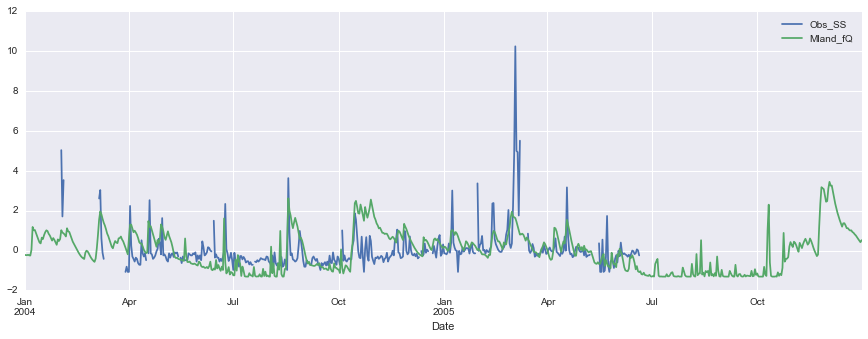

In [64]:
# Add some suspended sed to Mland, as a simple linear function of instream discharge
Mland2 = df['Mland'] + 1000*df['Dr']
fQ = df['Dr']

# Normalise M_land and suspended sediment concs and plot on same figure
log_Mland = np.sqrt(df['Msus_mg-l'])
log_Mland2 = np.sqrt(Mland2)
log_fQ = np.sqrt(fQ)
df[df['Obs_SS']==0] = 0.5
log_SSobs = np.sqrt(df['Obs_SS'])

Mland_norm = (log_Mland - np.mean(log_Mland))/np.std(log_Mland)
Mland_norm.name = 'Msus_mg-l'
Mland2_norm = (log_Mland2 - np.mean(log_Mland2))/np.std(log_Mland2)
Mland2_norm.name = 'Mland_fQ'
fQ_norm = (log_fQ - np.mean(log_fQ))/np.std(log_fQ)
fQ_norm.name = ('Normalised_Q')
SSobs_norm = (log_SSobs - np.mean(log_SSobs))/np.std(log_SSobs)
norm_df = pd.concat([Mland_norm, Mland2_norm, fQ_norm, SSobs_norm],axis=1)

fig4 = norm_df[['Obs_SS', 'Mland_fQ']].plot(subplots=False,figsize=(15, 5))

# plt.savefig(r'M:\Working\NewModel\ModelOutputs\sed_tests5.png')

# fig5 = norm_df.boxplot(return_type ='dict', figsize=(1,3))

In [65]:
# Work out the concentration of sediment in the stream and plot it properly

sim_SS = df['Vr']

In [66]:
df.sort_index(axis=1)

,D_snow,Dr,Mland,Msus,Msus_mg-l,Obs_PP,Obs_Q_cumecs,Obs_SRP,Obs_SS,Obs_TDP,Obs_TP,Qg,Qq,Qr,Qs,Sim_Q_cumecs,Sim_Vr_l,Vg,Vr,Vs
Date,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.0000,1.015943,51.831476,67.687057,5.609631,NaN,0.519719,NaN,NaN,NaN,NaN,0.983569,0.022200,1.016551,0.027162,0.607920,12066223.600705,59.014131,0.233389,291.250609
2004-01-02,0.0000,1.051658,24.032173,64.611651,5.262748,NaN,0.452732,NaN,NaN,NaN,NaN,0.968993,0.011700,1.052405,0.176891,0.629291,12277170.694319,58.139568,0.237469,291.652016
2004-01-03,0.0000,1.058094,7.635281,61.014699,4.970784,NaN,0.623296,NaN,NaN,NaN,NaN,0.955244,0.004500,1.051975,0.226187,0.633142,12274663.592681,57.314629,0.237421,291.521491
2004-01-04,0.0000,1.050843,31.604637,65.948543,5.382360,NaN,0.611836,NaN,NaN,NaN,NaN,0.941620,0.014700,1.048217,0.228077,0.628803,12252719.435638,56.497215,0.236997,292.071065
2004-01-05,0.0000,1.057586,3.591067,60.097154,4.897949,NaN,0.809897,NaN,NaN,NaN,NaN,0.929036,0.002400,1.051152,0.294370,0.632838,12269861.378547,55.742189,0.237328,291.730751
2004-01-06,0.0000,1.034595,19.666734,62.052225,5.113527,NaN,0.776016,NaN,NaN,NaN,NaN,0.916148,0.009900,1.028158,0.252446,0.619081,12134916.508522,54.968895,0.234718,291.934637
2004-01-07,0.0000,1.097149,194.751740,105.152365,8.346248,NaN,0.693237,NaN,NaN,NaN,NaN,0.904207,0.066900,1.108261,0.341531,0.656512,12598759.325023,54.252440,0.243690,295.807526
2004-01-08,0.0000,1.496526,952.326917,270.031309,18.195130,NaN,1.676253,NaN,NaN,NaN,NaN,0.898864,0.251100,1.537816,0.968421,0.895491,14840856.041568,53.931813,0.287057,311.130719
2004-01-09,0.0000,2.253036,2.043052,153.278172,8.394914,NaN,1.283964,NaN,NaN,NaN,NaN,0.918933,0.001500,2.327633,3.521786,1.348171,18258456.998136,55.135959,0.353162,307.509840
